In [7]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Conv2DTranspose, Dense, Reshape, Flatten, Conv2D, BatchNormalization, LeakyReLU, Dropout, Input

In [11]:
# Parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 256
LATENT_DIM = 100
EPOCHS = 50
SAVE_INTERVAL = 10

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [17]:
# Load MNIST dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5  # Normalizar entre [-1, 1]

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
# Generator model
def build_generator():
    model = tf.keras.Sequential([
        Input(shape=(LATENT_DIM,)),
        Dense(7 * 7 * 256, use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),
        Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    
    return model

In [9]:
# Discriminator model
def build_discriminator():
    model = tf.keras.Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(64, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(),
        Dropout(0.3),
        Conv2D(128, kernel_size=5, strides=2, padding='same'),
        LeakyReLU(),
        Dropout(0.3),
        Flatten(),
        Dense(1)
    ])
    
    return model

In [10]:
# Create the generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

In [13]:
# Definir optimizadores y función de pérdida
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Función de pérdida del discriminador
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Función de pérdida del generador
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
# Punto de control
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Función para generar imágenes y guardarlas
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.close()

In [ ]:
# Entrenamiento
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

# Bucle de entrenamiento
def train(dataset, epochs):
    seed = tf.random.normal([16, LATENT_DIM])
    for epoch in range(1, epochs + 1):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        if epoch % SAVE_INTERVAL == 0 or epoch == 1:
            print(f"Epoch {epoch}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
            generate_and_save_images(generator, epoch, seed)
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
# Train GAN model
train(train_dataset, EPOCHS)

In [ ]:
# Restore from the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f"✅ Checkpoint restaurado desde: {latest_checkpoint}")
else:
    print("❌ No se encontró ningún checkpoint.")

✅ Checkpoint restaurado desde: ./training_checkpoints\ckpt-6


In [ ]:
import numpy as np
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.metrics import pairwise_distances
from scipy import linalg

def preprocess_for_inception(images):
    images = tf.image.resize(images, [299, 299])
    images = tf.image.grayscale_to_rgb(images)
    return preprocess_input(images)

inception_model = InceptionV3(include_top=True, weights='imagenet', input_shape=(299, 299, 3))

def get_inception_features(images, batch_size=32):
    features = []
    for i in range(0, images.shape[0], batch_size):
        batch = images[i:i+batch_size]
        batch = preprocess_for_inception(batch)
        feats = inception_model(batch, training=False)
        features.append(feats)
    return tf.concat(features, axis=0).numpy()

def calculate_inception_score(images, splits=10):
    images = preprocess_for_inception(images)
    preds = tf.nn.softmax(inception_model(images)).numpy()
    split_scores = []

    for k in range(splits):
        part = preds[k * preds.shape[0] // splits: (k+1) * preds.shape[0] // splits]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i]
            scores.append(np.sum(pyx * (np.log(pyx + 1e-10) - np.log(py + 1e-10))))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

def calculate_fid(real_images, fake_images):
    act1 = get_inception_features(real_images)
    act2 = get_inception_features(fake_images)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

def calculate_kid(real_images, fake_images, subset_size=100):
    act1 = get_inception_features(real_images)
    act2 = get_inception_features(fake_images)

    n = min(subset_size, act1.shape[0], act2.shape[0])
    x, y = act1[:n], act2[:n]

    xx = np.dot(x, x.T)
    yy = np.dot(y, y.T)
    xy = np.dot(x, y.T)

    def mmd2(a, b):
        return np.mean(a) + np.mean(b) - 2 * np.mean(xy)

    return mmd2(xx, yy)

def calculate_precision_recall(real_images, fake_images, k=5, threshold=0.8):
    act1 = get_inception_features(real_images)
    act2 = get_inception_features(fake_images)

    dists_real_fake = pairwise_distances(act2, act1)

    # Precision: cuántas muestras generadas están cerca de alguna real
    precision = np.mean(np.min(dists_real_fake, axis=1) < threshold)

    # Recall: cuántas reales están cubiertas por alguna generada
    recall = np.mean(np.min(dists_real_fake, axis=0) < threshold)

    return precision, recall

def evaluate_gan(generator, real_dataset, latent_dim=100, num_samples=500):
    print("📊 Evaluando GAN...")

    # Obtener imágenes reales
    real_images = []
    for batch in real_dataset:
        real_images.append(batch)
        if len(tf.concat(real_images, axis=0)) >= num_samples:
            break
    real_images = tf.concat(real_images, axis=0)[:num_samples]

    # Imágenes falsas
    noise = tf.random.normal([num_samples, latent_dim])
    fake_images = generator(noise, training=False)

    # Calcular métricas
    is_mean, is_std = calculate_inception_score(fake_images)
    fid = calculate_fid(real_images, fake_images)
    kid = calculate_kid(real_images, fake_images)
    precision, recall = calculate_precision_recall(real_images, fake_images)

    print(f"\n📈 Inception Score: {is_mean:.4f} ± {is_std:.4f}")
    print(f"📉 FID: {fid:.4f}")
    print(f"🔁 KID: {kid:.4f}")
    print(f"✅ Precision: {precision:.4f}")
    print(f"♻️ Recall: {recall:.4f}")

evaluate_gan(generator, train_dataset)

📊 Evaluando GAN...


: 

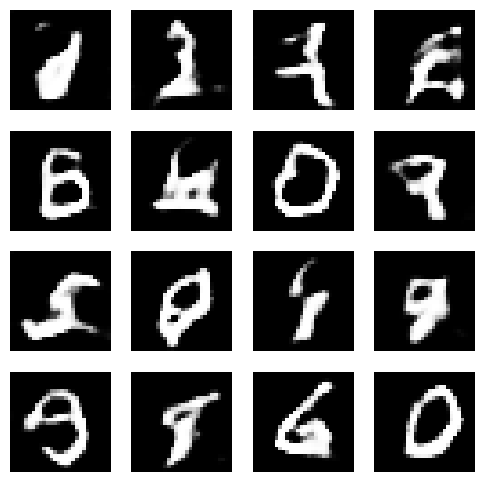

In [20]:
noise = tf.random.normal([16, 100])  # Tamaño del vector latente
generated_images = generator(noise, training=False)

# Mostrar imágenes generadas
import matplotlib.pyplot as plt

def plot_images(images, n=4):
    _, axs = plt.subplots(n, n, figsize=(6,6))
    for i in range(n*n):
        ax = axs[i // n, i % n]
        ax.imshow(images[i, :, :, 0], cmap='gray')
        ax.axis('off')
    plt.show()

plot_images(generated_images)